## 0.0 IMPORTS

In [1]:
import math
import pickle
import random
import datetime
import inflection

import pandas              as pd
import numpy               as np
import matplotlib.pyplot   as plt
import seaborn             as sns
import xgboost             as xgb
import matplotlib.gridspec as GridSpec

from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy
from scipy                 import stats as ss
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso, Ridge
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


### 0.1 Helper Functions

In [2]:
def mean_absolute_percentage_error(y,y_hat):
    return np.mean(np.abs((y - y_hat)/ y))

def mean_percentage_error(y,y_hat):
    return np.mean((y - y_hat)/ y)

def ml_error(model_name,y,y_hat):
    mae  = mean_absolute_error(y,y_hat)
    mape = mean_absolute_percentage_error(y,y_hat)
    rmse = np.sqrt(mean_squared_error(y,y_hat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cramer_v(x,y):
    contingency_matrix = pd.crosstab(x,y).values
    n = contingency_matrix.sum()
    r,k = contingency_matrix.shape
    chi2 = ss.chi2_contingency(contingency_matrix)[0]
    
    chi2_tilde = max(0, chi2 - ((k-1)*(r-1))/(n-1))
    k_tilde = k - ((k-1)**2)/(n-1)
    r_tilde = r - ((r-1)**2)/(n-1)
    
    v_tilde = np.sqrt((chi2_tilde/n)/min(k_tilde-1,r_tilde-1))
    return v_tilde

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list  =[]
    mape_list =[]
    rmse_list =[]

    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'KFold Number:{k}\n')
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filetring dataset

        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset

        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']


        #model
        m = model.fit(xtraining,ytraining)
        #prediction
        y_hat = m.predict(xvalidation)
        #performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation),np.expm1(y_hat))

        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
        'MAE_CV':np.round(np.mean(mae_list),2).astype(str)+' +/- '+np.round(np.std(mae_list),2).astype(str),
        'MAPE_CV':np.round(np.mean(mape_list),2).astype(str)+' +/- '+np.round(np.std(mape_list),2).astype(str),
        'RMSE_CV':np.round(np.mean(rmse_list),2).astype(str)+' +/- '+np.round(np.std(rmse_list),2).astype(str)},index=[0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'GridSpec']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 0.2 File Paths

In [4]:
data_path  = '/home/dimitri/github/DsEmProducao/data/'

mindmap_img = 'img/mindmap_hypothesis.png'
results_img = 'img/complete_result.png'

pickle_parameter_paths = '/home/dimitri/github/DsEmProducao/parameter/'
pickle_model_paths     = '/home/dimitri/github/DsEmProducao/model/'

### 0.3 Loading Data

In [5]:
df_sales_raw = pd.read_csv(data_path+'train.csv', low_memory=False)
df_store_raw = pd.read_csv(data_path+'store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

In [6]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
628306,232,7,2013-12-15,0,0,0,0,0,0,c,c,13570.0,5.0,2010.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec"


## 1.0 DATA DESCRIPTION

### 1.1 Rename Columns

In [7]:
df1 = df_raw.copy()

In [8]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename columns
df1.columns = cols_new

### 1.2 Data Dimension

In [9]:
print("number of rows:{}".format(df1.shape[0]))
print("number of columns:{}".format(df1.shape[1]))

number of rows:1017209
number of columns:18


### 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA's

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA's

In [12]:
max_value = df1['competition_distance'].max()
max_value

75860.0

In [13]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

# promo_interval
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.sample(8).T

,1012246,277501,658022,758808,805466,570293,923483,32857
store,612,1091,958,279,107,199,1049,523
day_of_week,6,2,2,2,2,3,2,4
date,2013-01-05 00:00:00,2014-11-18 00:00:00,2013-11-19 00:00:00,2013-08-20 00:00:00,2013-07-09 00:00:00,2014-02-05 00:00:00,2013-03-26 00:00:00,2015-07-02 00:00:00
sales,5921,6945,4753,4953,6269,8741,4576,14260
customers,415,643,582,451,845,595,641,1553
open,1,1,1,1,1,1,1,1
promo,0,0,1,0,0,1,1,1
state_holiday,0,0,0,0,0,0,0,0
school_holiday,0,0,0,1,1,0,1,0
store_type,d,a,a,d,a,d,a,c


### 1.6 Change Types

In [15]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

### 1.7 Descriptive Statistical

#### 1.7.1 numerical Attributes

In [16]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [17]:
#Central Tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion Tendency - std,min,max,range,skew,kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


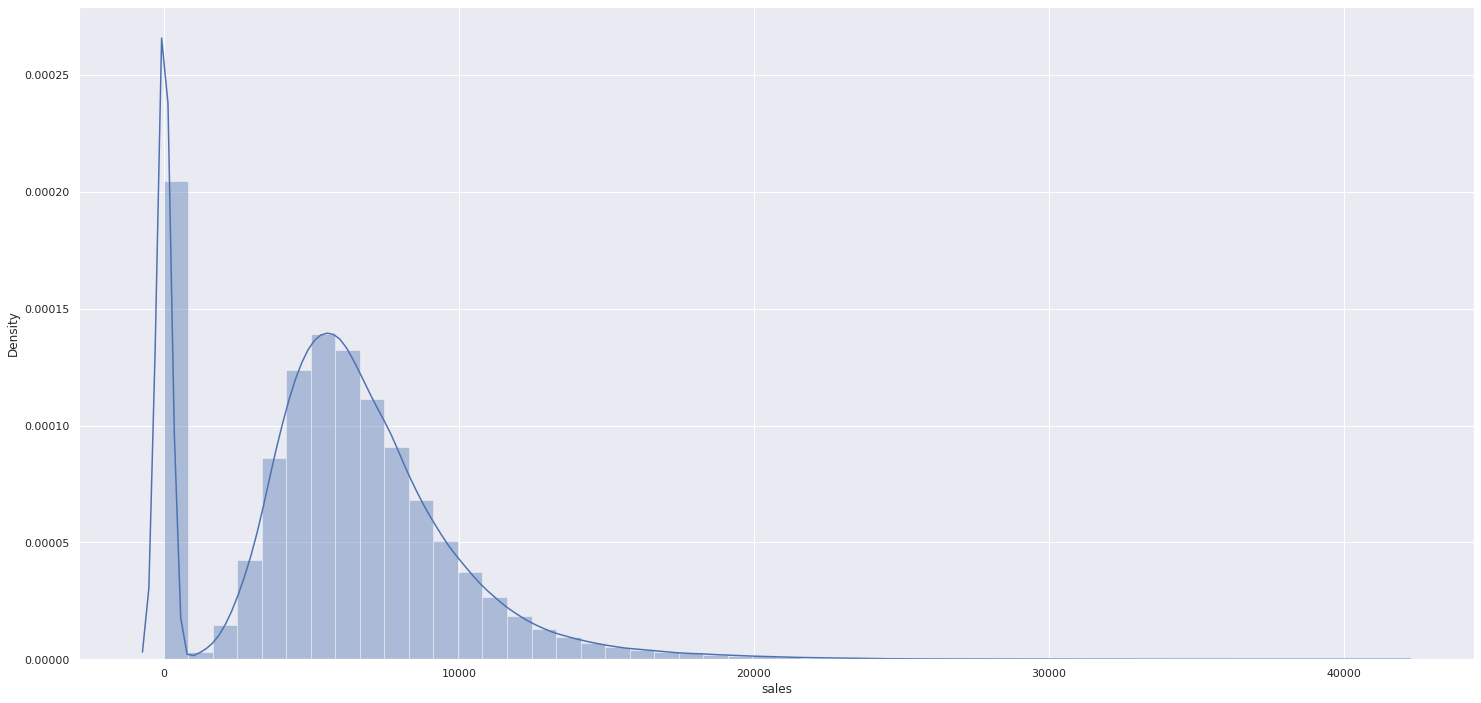

In [18]:
sns.distplot(df1['sales'])

#### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

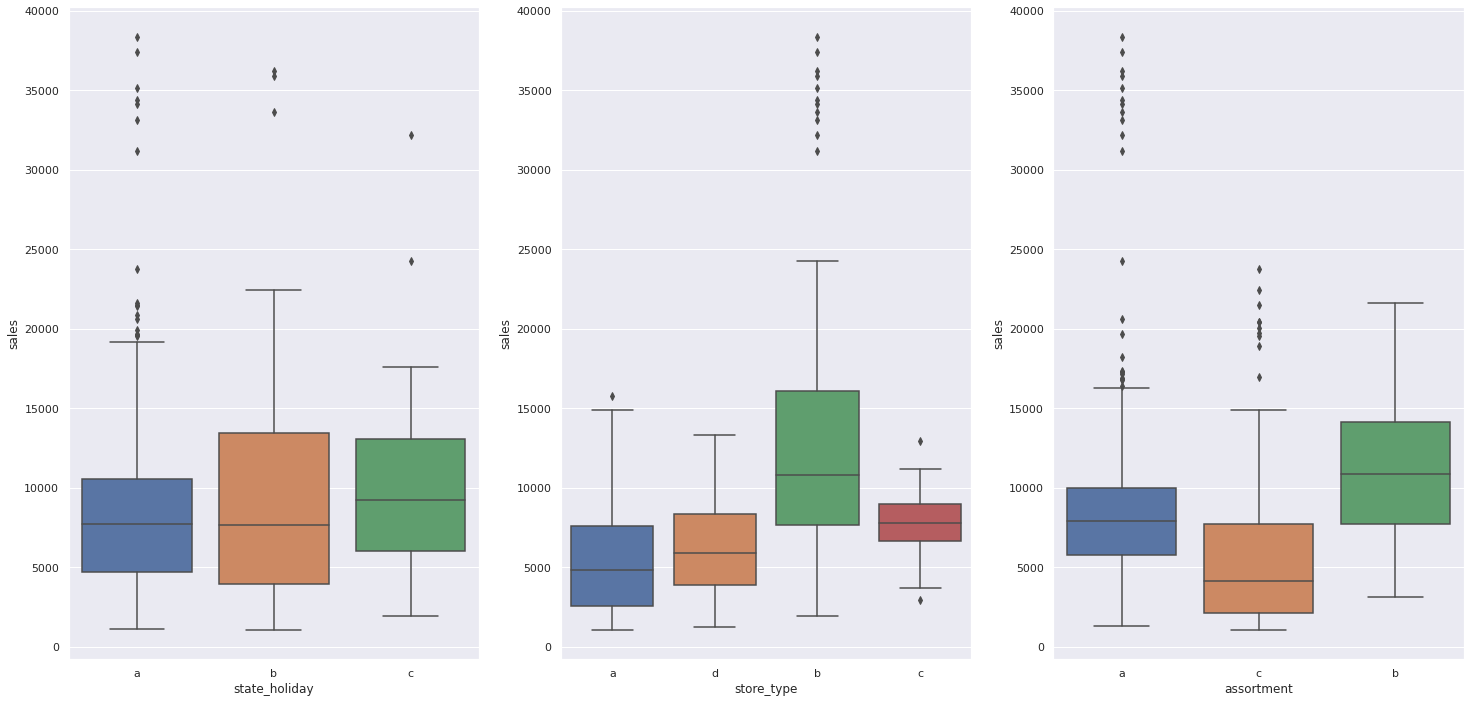

In [20]:
aux1 = df1[((df1['state_holiday'] != '0') & df1['sales'] >0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

## 2.0 FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

### 2.1 Mind Map Hypothesis

In [22]:
Image(mindmap_img)

FileNotFoundError: No such file or directory: 'img/mindmap_hypothesis.png'

FileNotFoundError: No such file or directory: 'img/mindmap_hypothesis.png'

<IPython.core.display.Image object>

### 2.1 Hypothesis Creation

#### 2.1 Mind Map Hypothesis

##### 2.1.1 Lojas Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.**  Lojas com maior sortemento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

##### 2.1.2 Produto Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

##### 2.1.3 Temporal Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2 Hypothesis final list

**1.**  Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# week
df2['week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] ,month= x['competition_open_since_month'], day= 1 ), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days = 7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#state holiday and assortment
df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [24]:
df2.sample(8).T

,455730,782910,800132,807738,831368,924644,364110,592865
store,481,966,348,149,364,1095,686,471
day_of_week,1,2,7,7,7,1,7,4
date,2014-05-19 00:00:00,2013-07-30 00:00:00,2013-07-14 00:00:00,2013-07-07 00:00:00,2013-06-16 00:00:00,2013-03-25 00:00:00,2014-08-17 00:00:00,2014-01-16 00:00:00
sales,6531,6033,0,0,0,6717,0,5373
customers,552,718,0,0,0,826,0,475
open,1,1,0,0,0,1,0,1
promo,1,1,0,0,0,1,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,1,0,0,0,1,0,0
store_type,c,a,a,d,a,a,a,d


## 3.0 FEATURE FILTERING

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Rows Filtering

In [27]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

### 3.2 columns Selection

In [28]:
cols_drop = ['open','customers','promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 EXPLORATORY DATA ANALISYS

In [30]:
df4 = df3.copy()

### 4.1 Univariate Analisys

#### 4.1.1Response Variable

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


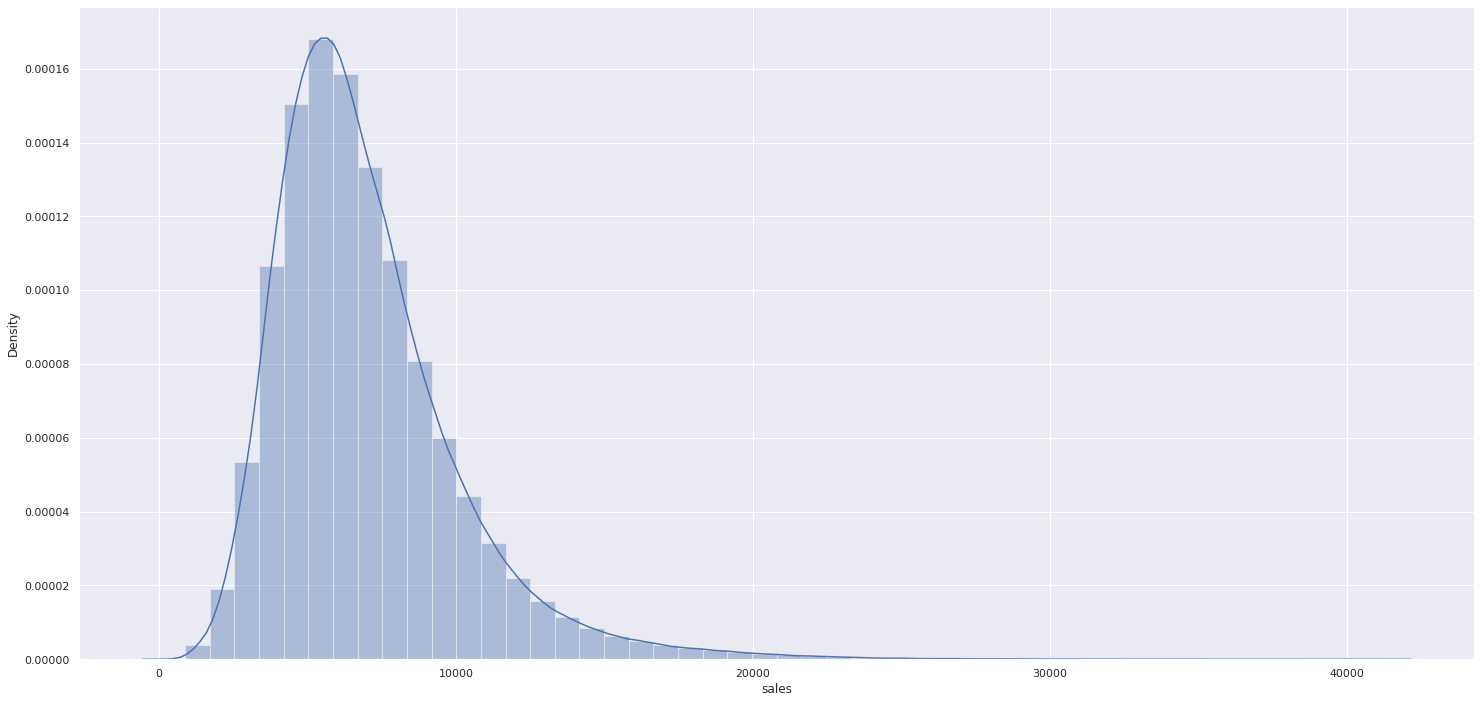

In [31]:
sns.distplot(df4['sales'])

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


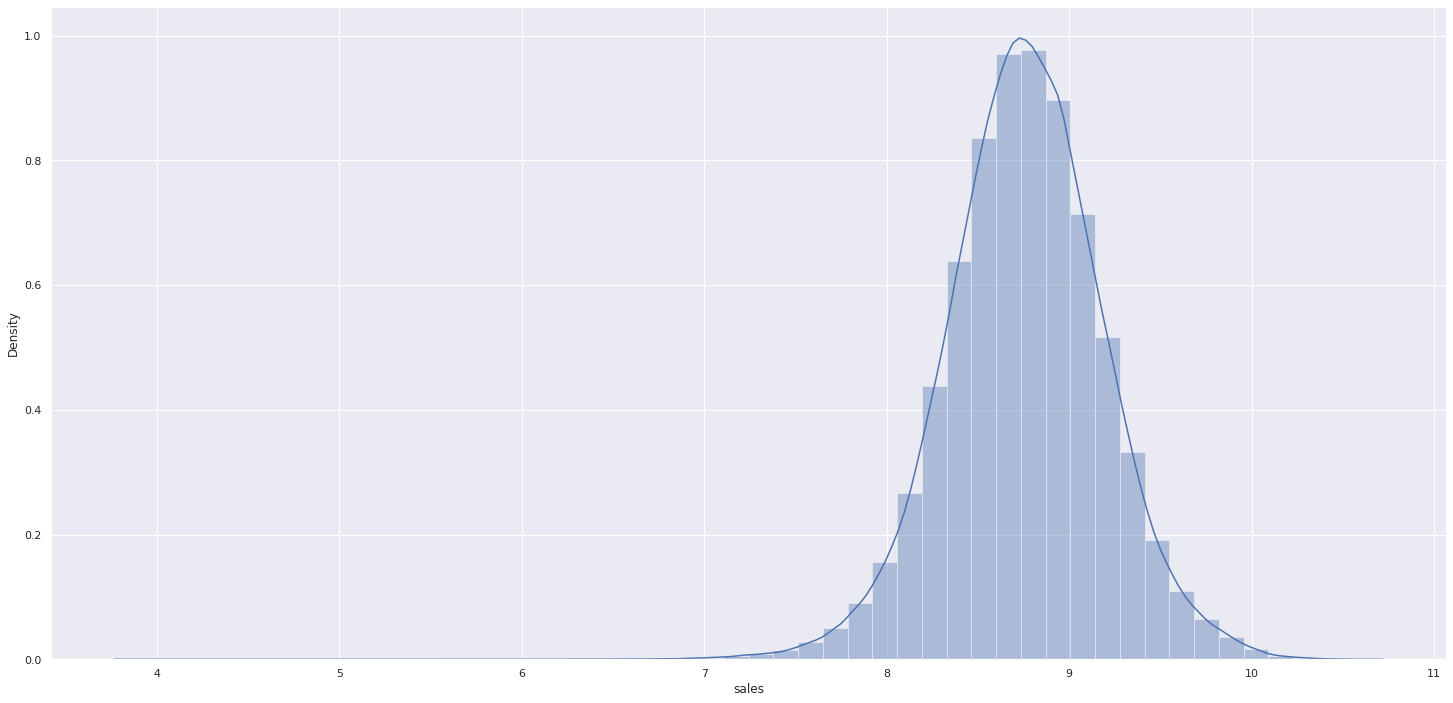

In [32]:
sns.distplot(np.log1p(df4['sales']))

#### 4.1.2 Numerical Variable

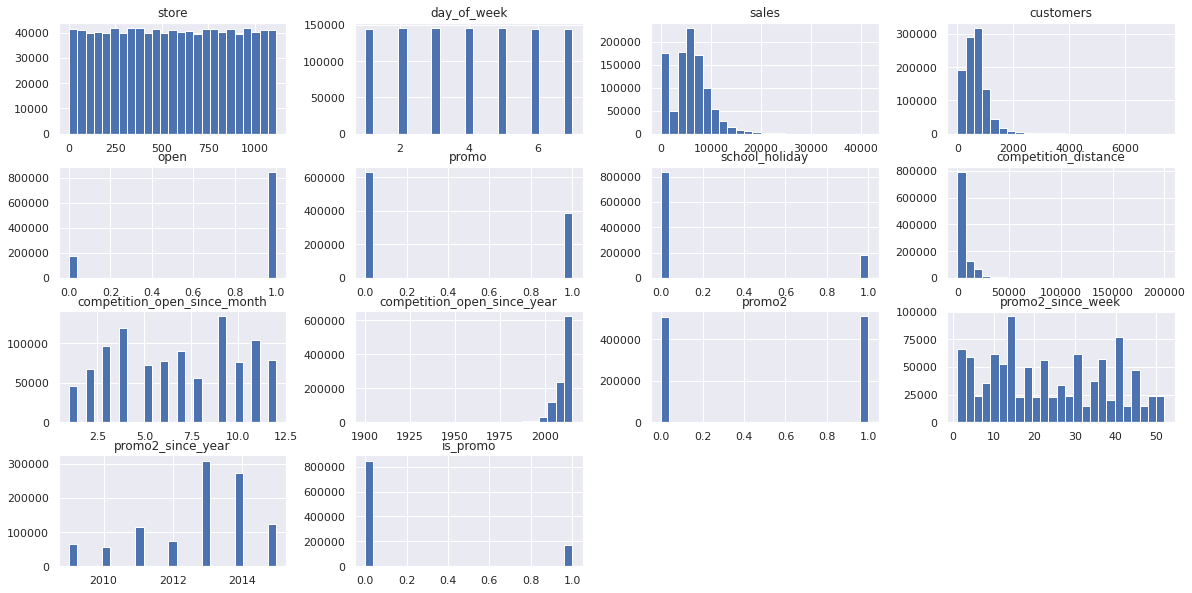

In [33]:
num_attributes.hist(figsize =(20,10),bins = 25);

Tarefa de Casa: Elaborar explicações qualitativas sobre os resultados dos histogramas das variáveis. Formando frases simples mesmo, sem nada muito elaborado

#### 4.1.3 Categorical Variable

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [35]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in 

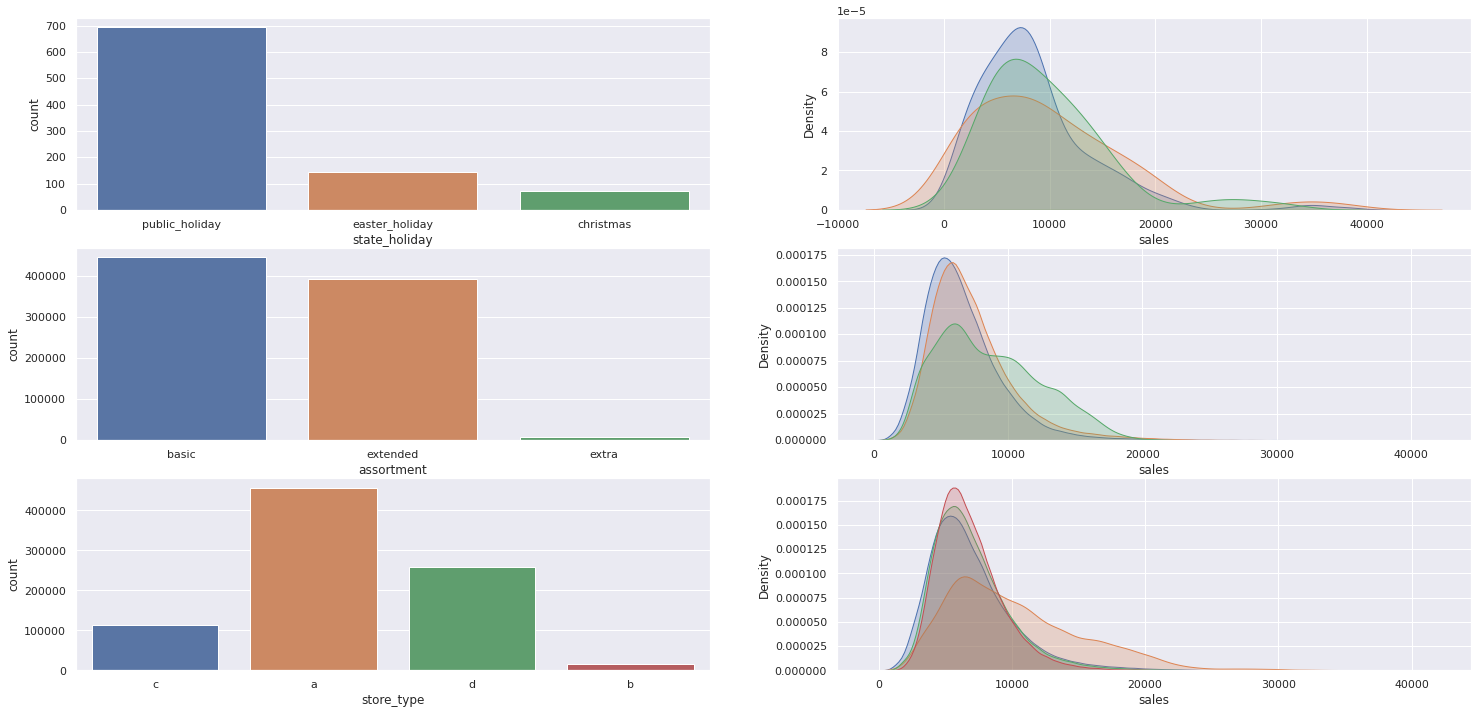

In [36]:
#state_holiday

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label=('public_holiday'), shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label=('easter_holiday'), shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label=('christmas'), shade=True)

#assortment
plt.subplot(3,2,3)
sns.countplot(df4['assortment'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label=('basic'), shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label=('extended'), shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label=('extra'), shade=True)

#store_type
plt.subplot(3,2,5)
sns.countplot(df4['store_type'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label=('a'), shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label=('b'), shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label=('c'), shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label=('d'), shade=True) 

### 4.2 Bivariate Analisys

#### **1.**  Lojas com maior sortimento deveriam vender mais.

Resposta: *** FALSO! *** Lojas com maior sortimento vendem ***MENOS***. Mais informação sobre a quantidade das lojas poderia expandir essa análise.

In [37]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

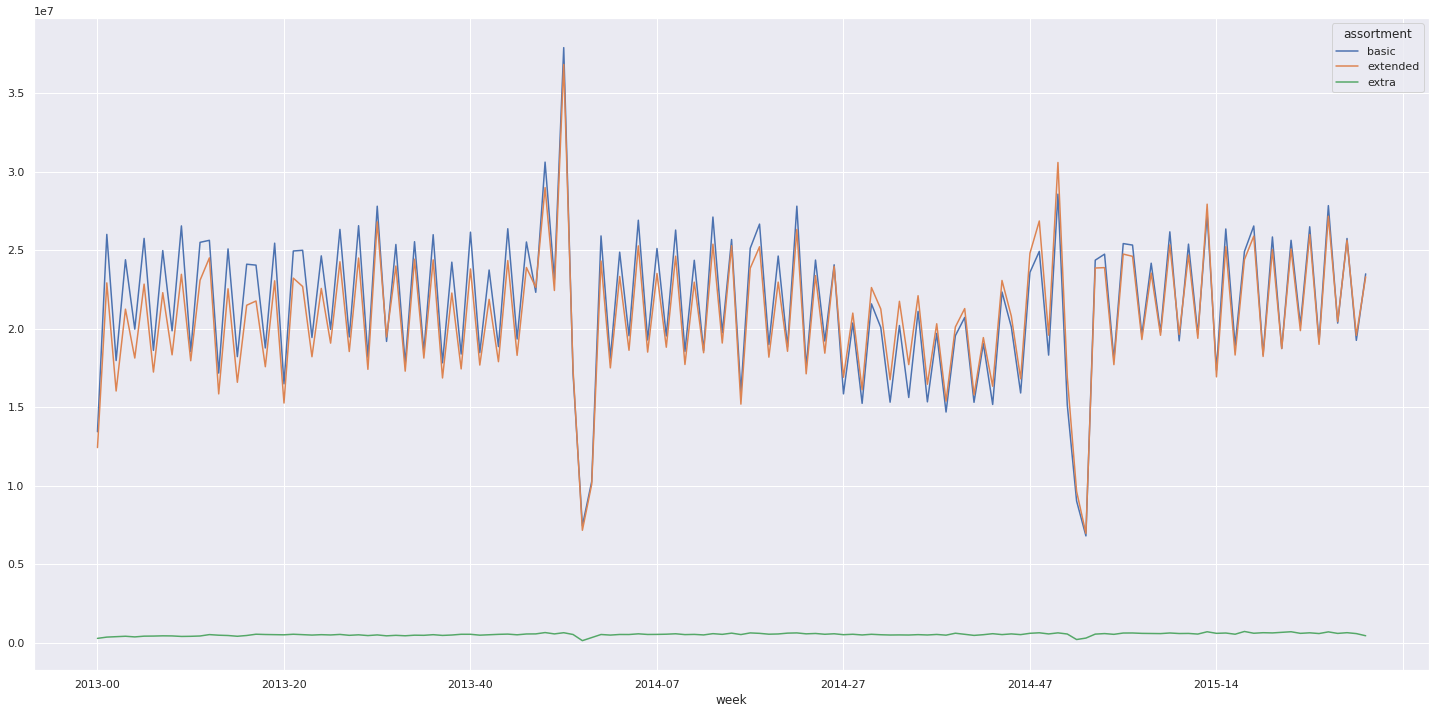

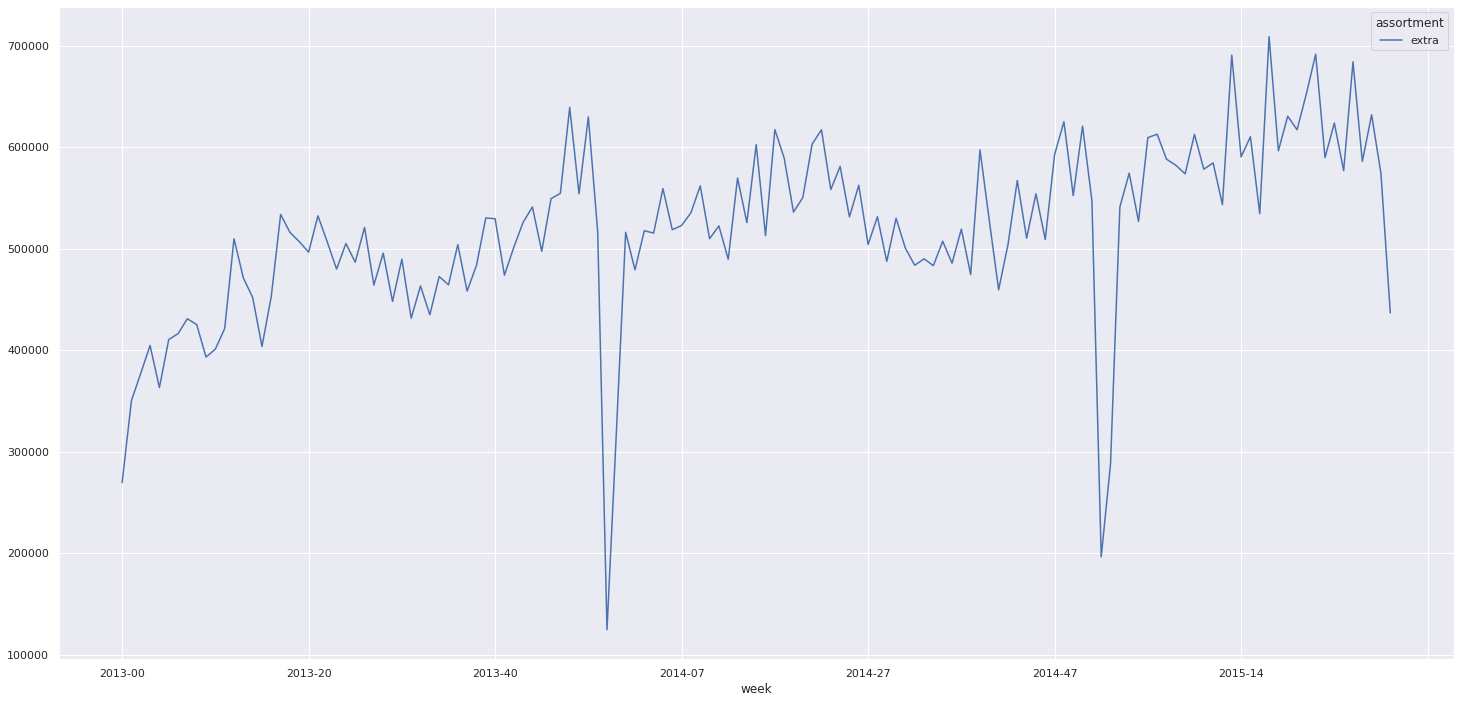

In [38]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
aux1['sales%'] = aux1['sales']/aux1['sales'].sum()
#aux1.head()
#sns.barplot(x='assortment',y='sales%',data = aux1);

aux2 = df4[['week','assortment','sales']].groupby(['week','assortment']).sum().reset_index()
aux2.pivot(index='week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='week',columns='assortment',values='sales').plot()


#### **2.** Lojas com competidores mais próximos deveriam vender menos.
***FALSA!!!*** Lojas com competidores mais próximos vendem mais.

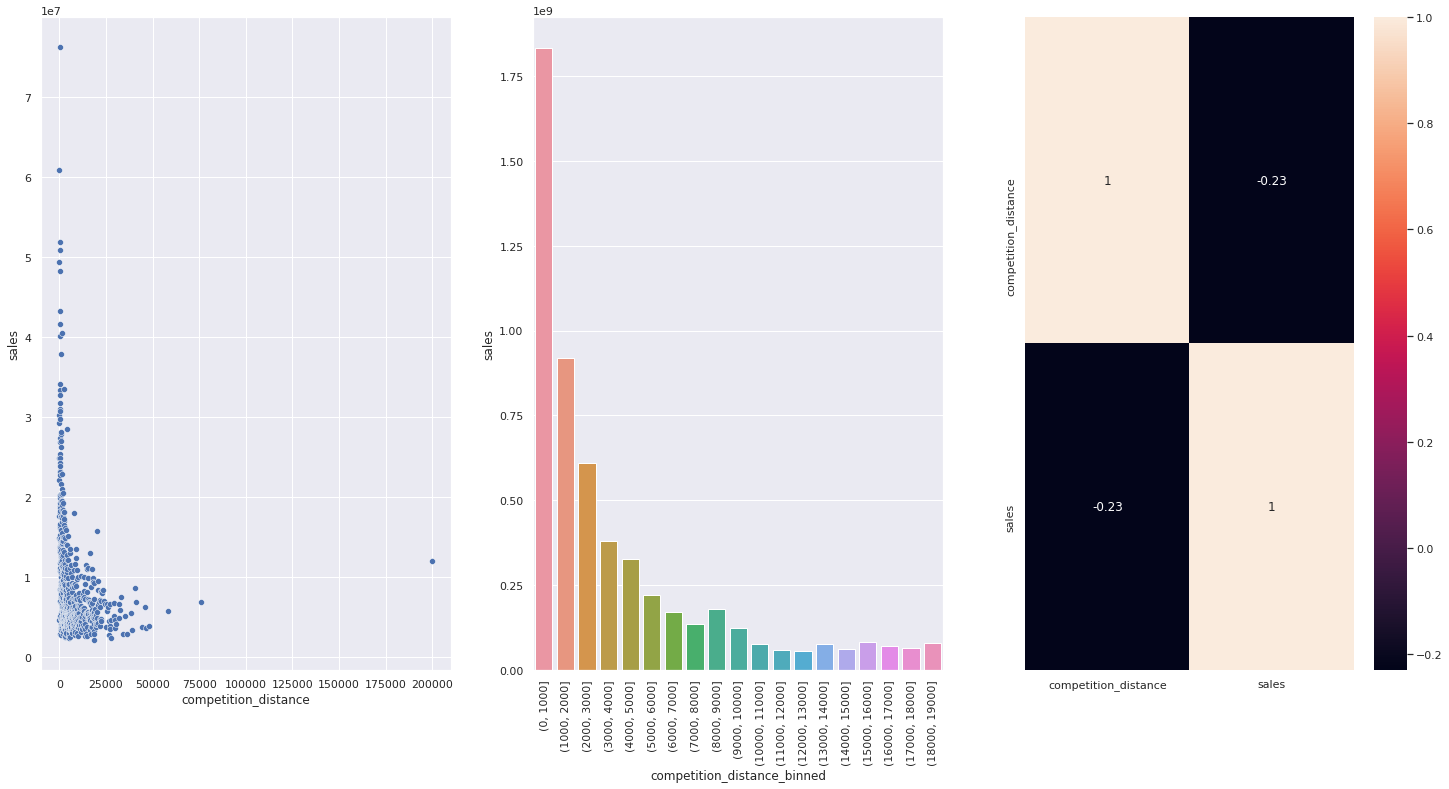

In [39]:
plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance',y='sales',data=aux1);


plt.subplot(1,3,2)
bins = [x for x in range(0,20000,1000)]
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)



In [40]:
aux1['competition_distance_binned'].value_counts()

(0, 1000]         93
(1000, 2000]      83
(2000, 3000]      68
(3000, 4000]      58
(4000, 5000]      43
(5000, 6000]      39
(8000, 9000]      29
(6000, 7000]      29
(7000, 8000]      22
(9000, 10000]     20
(10000, 11000]    14
(18000, 19000]    14
(13000, 14000]    13
(15000, 16000]    13
(16000, 17000]    12
(17000, 18000]    11
(11000, 12000]    11
(12000, 13000]    10
(14000, 15000]     9
Name: competition_distance_binned, dtype: int64

#### **3.** Lojas com competidores a mais tempo deveriam vender mais.
***FALSA!*** Lojas com competidores a mais tempo vendem ***MENOS***!

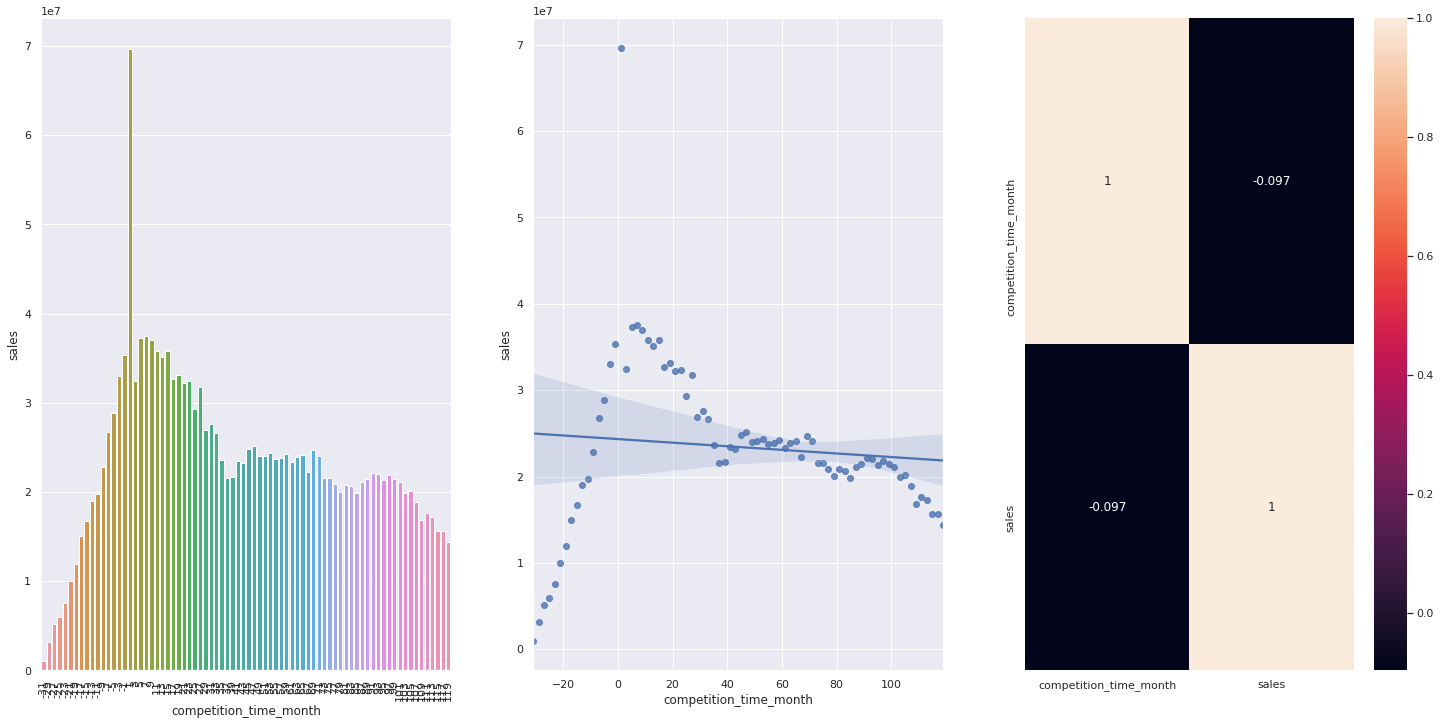

In [41]:
plt.subplot(1,3,1)

aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month']) != 0]
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month',y='sales', data=aux2);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'),annot=True)


#### **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
 ***FALSA!!!*** Lojas vendem menos com mais dias de promoção!

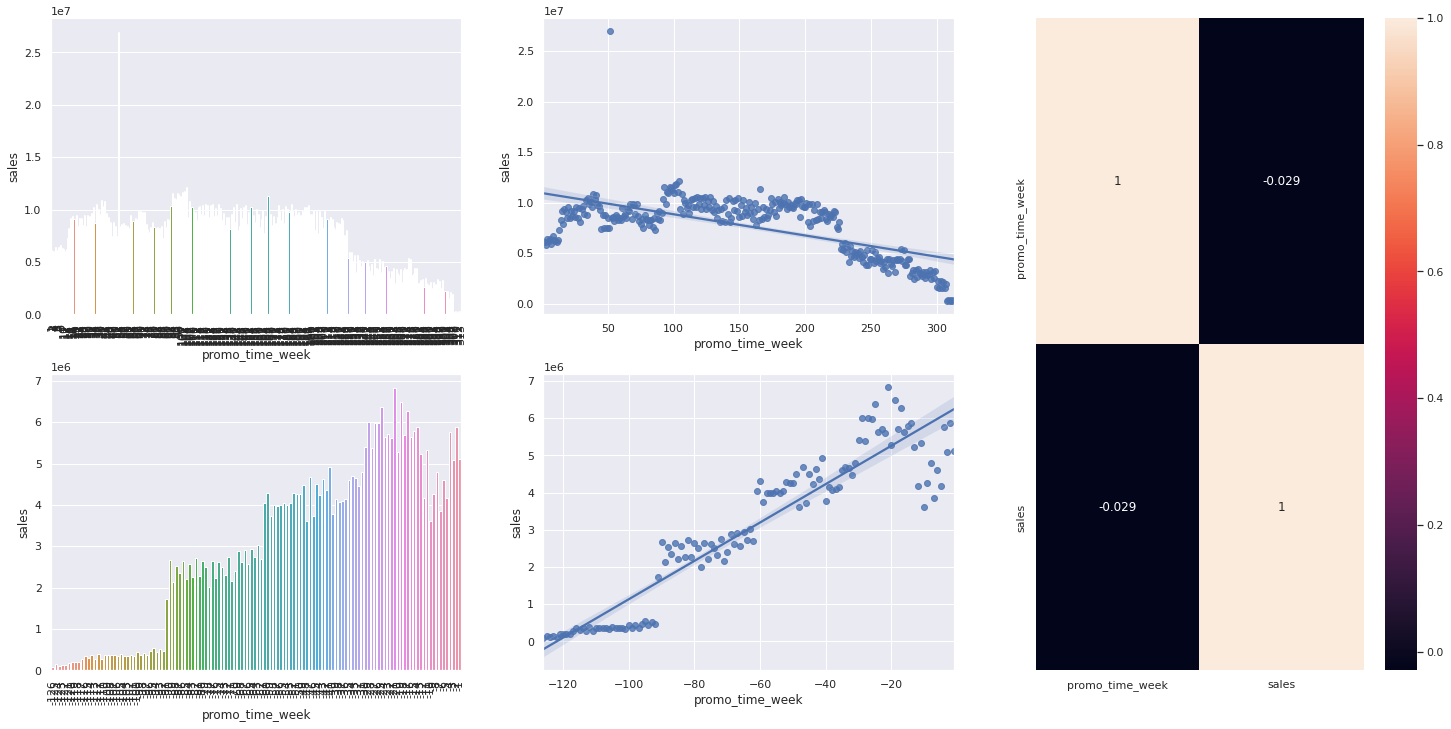

In [42]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
plt.xticks(rotation=90)
sns.barplot(x='promo_time_week',y='sales',data=aux2);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
plt.xticks(rotation=90)
sns.barplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);


#### **5.** <s> Lojas com mais dias de promoção deveriam vender mais.</s>

#### **6.** Lojas com mais promoções consecutivas deveriam vender mais.
***FALSA!!!*** Lojas com mais promoções consecutivas valem menos.

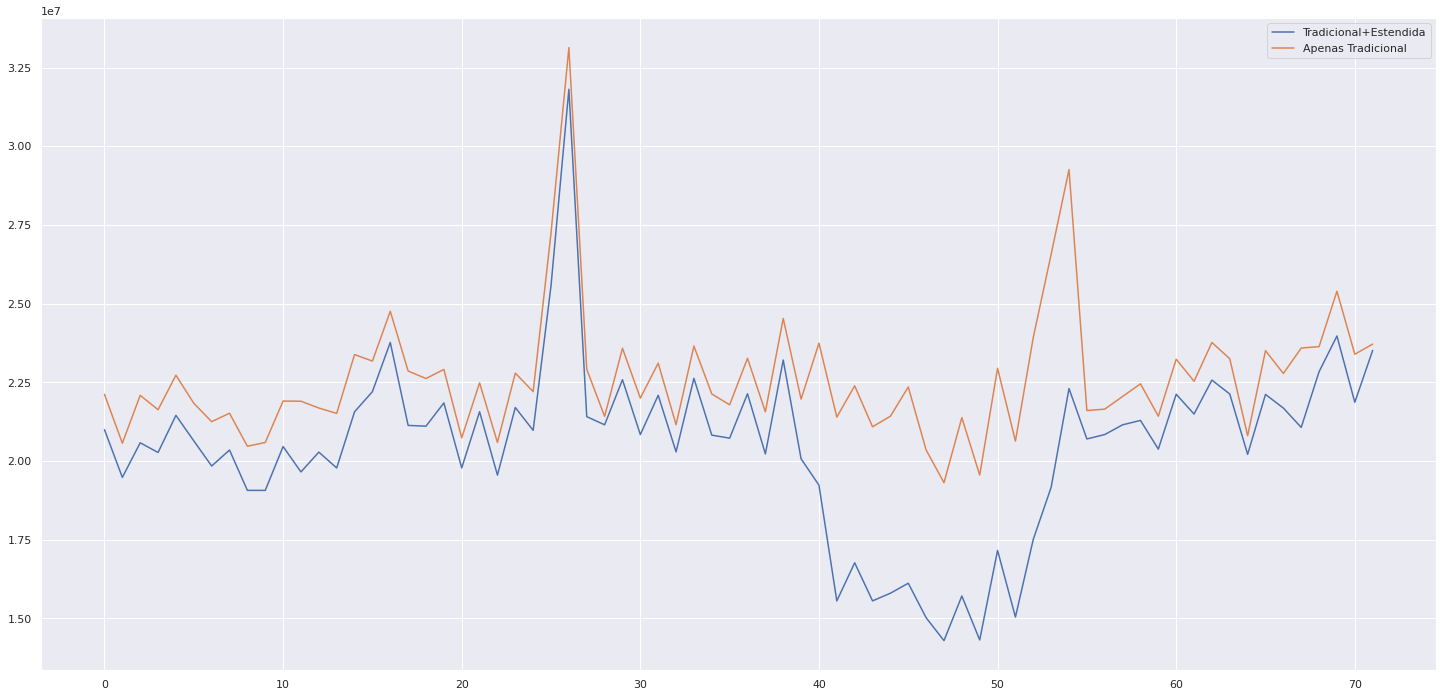

In [43]:
#aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] ==1)][['week_of_year','sales']].groupby('week_of_year').sum().reset_index()
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] ==1)][['week','sales']].groupby('week').sum().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] ==0)][['week','sales']].groupby('week').sum().reset_index()

ax = aux1.plot()
aux2.plot(ax=ax)
ax.legend(['Tradicional+Estendida','Apenas Tradicional'])

#### **7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
***FALSA!!!*** Lojas vendem MENOS durante os natais!

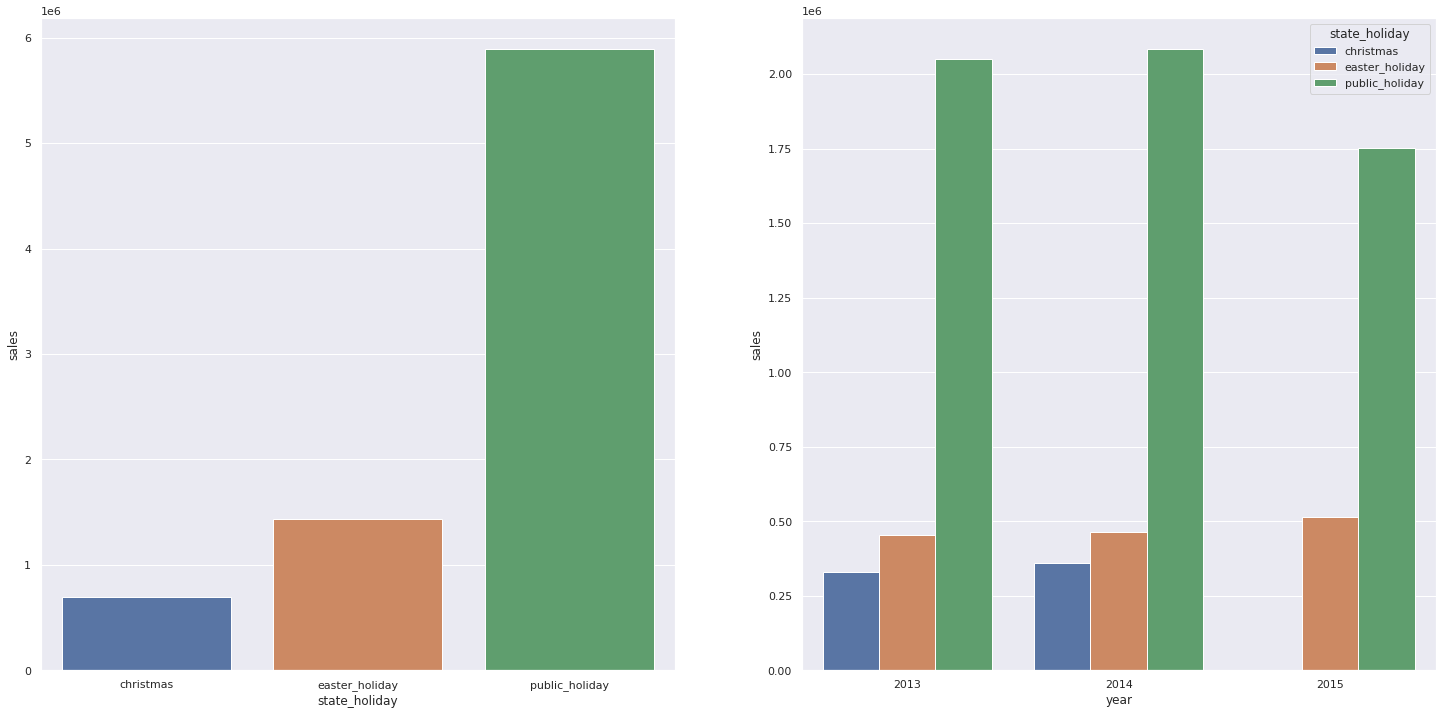

In [44]:
aux = df4[df4['state_holiday'] != "regular_day"]

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x= 'year', hue='state_holiday', y = 'sales', data = aux2);

#### **8.** Lojas deveriam vender mais ao longo dos anos.
***FALSA!!!***, As lojas estão vendendo menos ao longo dos anos (mas 2015 ainda não está completo).

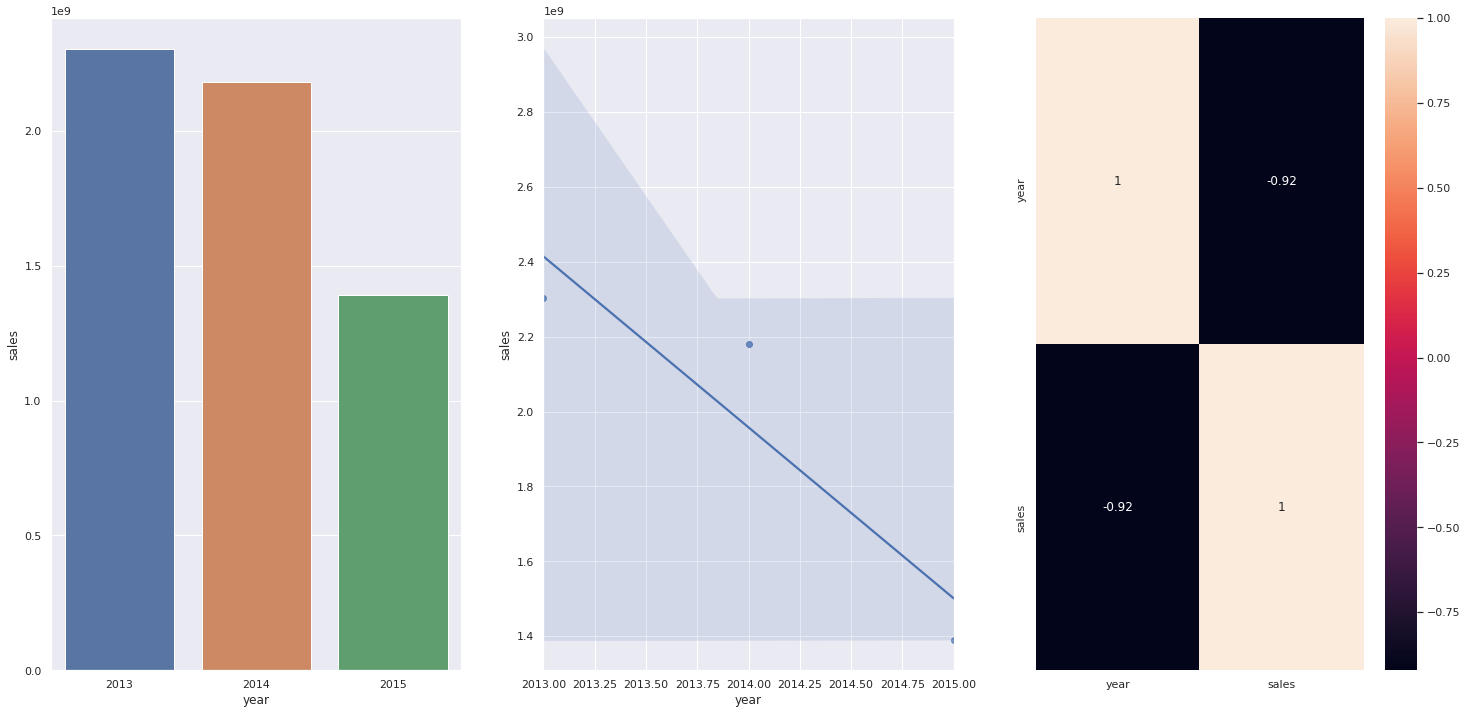

In [45]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **9.** Lojas deveriam vender mais no segundo semestre do ano.
***FALSA!!!*** As lojas vendem bem mais no primeiro semestre do ano.

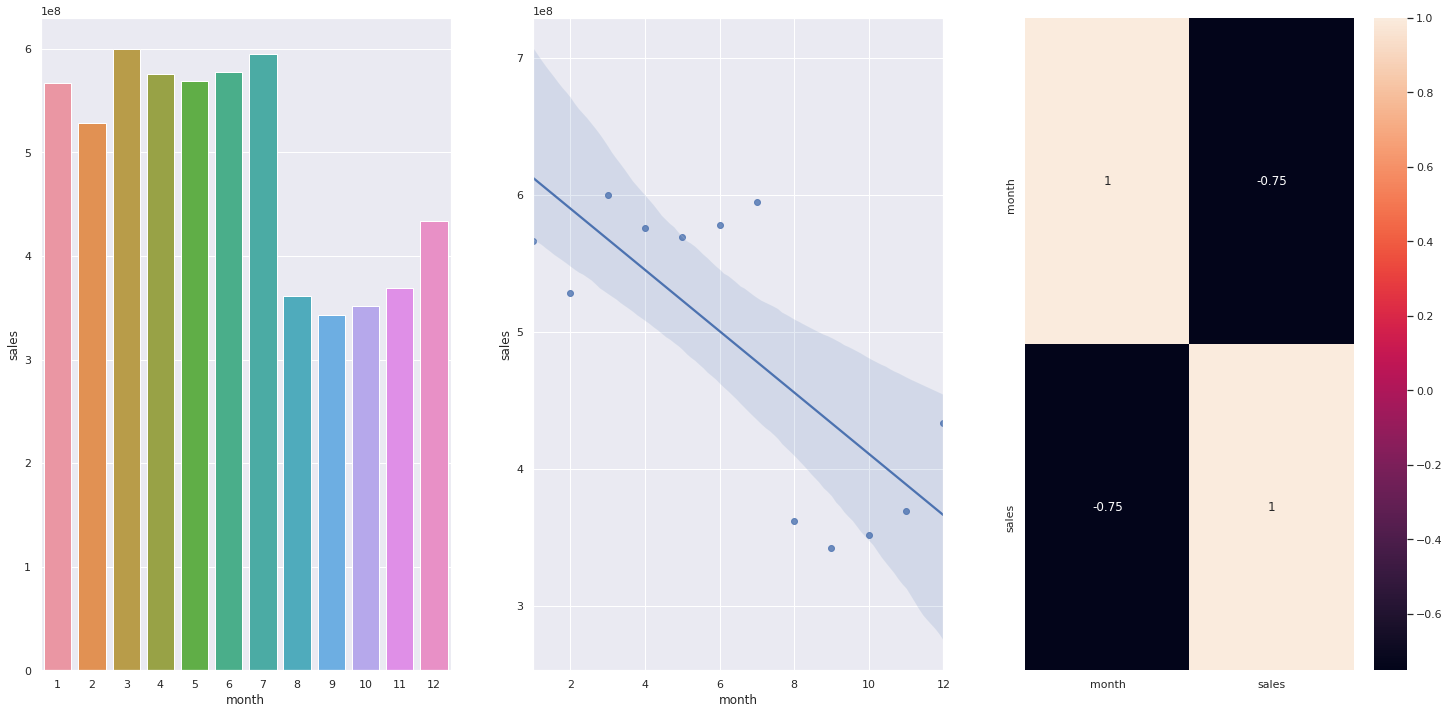

In [46]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 4.3 Multivariate Analisys

#### 4.3.1 - Numerical Attributes

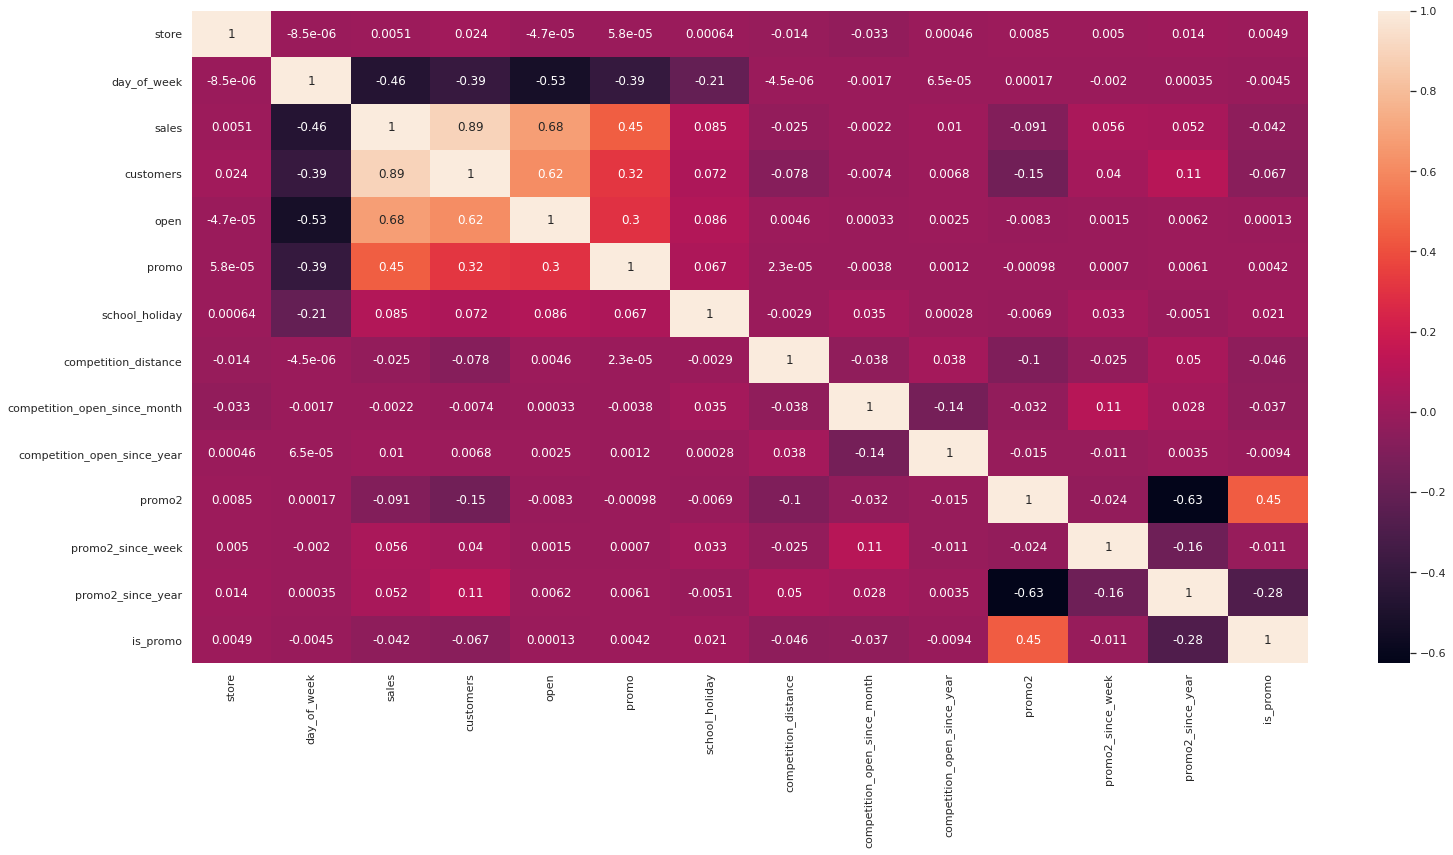

In [47]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#### 4.3.2 - Categorical Attributes

In [48]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


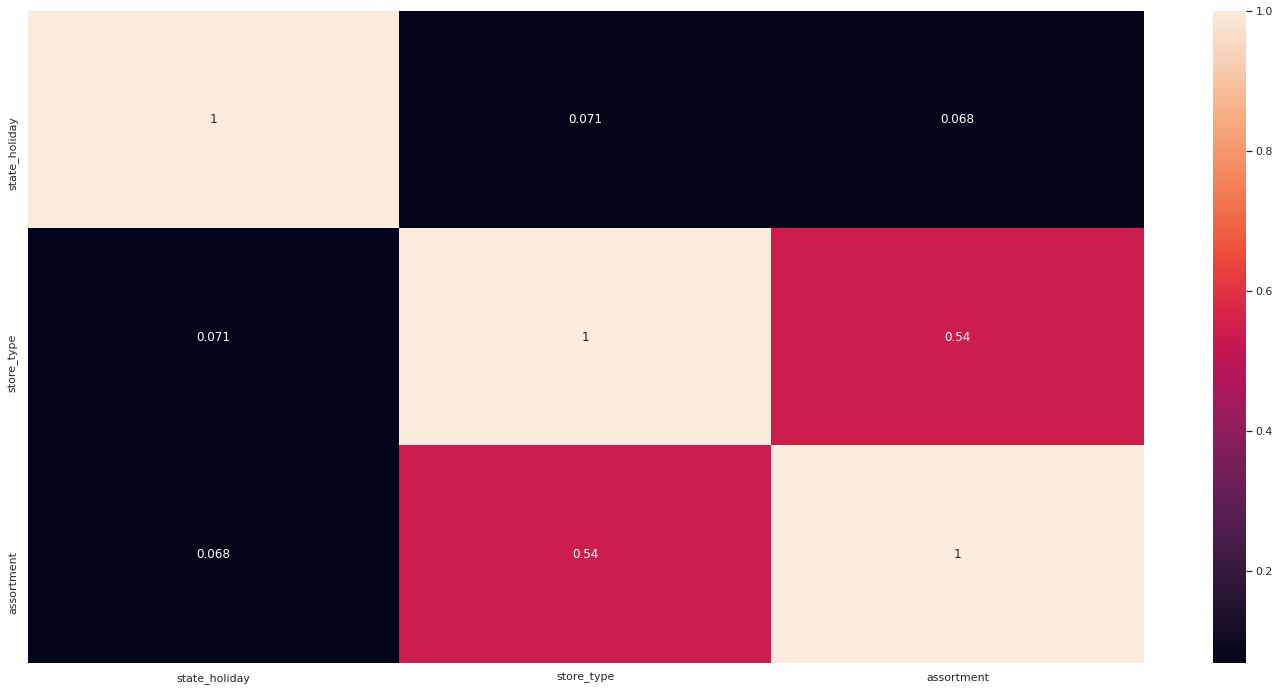

In [49]:
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
               'store_type':[a4,a5,a6],
               'assortment':[a7,a8,a9]})
d=d.set_index(d.columns)
sns.heatmap(d,annot=True)

## 5.0  DATA PREPARATION

In [50]:
df5 = df4.copy()

### 5.1 Normalization

Os dados não apresentam nenhuma variável com distribuição (próxima da) Gaussiana. O processo de normalização de dados (escalá-los para uma distribuição com média $\mu = 0$ e desvio $\sigma^2$ = 1) é especialmente eficaz nesse tipo de distribuição; portanto, não normalizarei nenhuma das features.

(mais informação sobre a distribuição pode ser vista na seção 4.1.2)

### 5.2 Rescaling

In [51]:
a = df5.select_dtypes(include = ['int64','float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#pickle.dump(rs, open(pickle_parameter_paths+'competition_distance_scaler.pkl','wb')) #saving scaler for use in class - made in step 10

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(rs, open('year_scaler.pkl','wb'))
# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#pickle.dump(mms, open(pickle_parameter_paths+'competition_time_month_scaler.pkl','wb')) #saving scaler for use in class - made in step 10

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
#pickle.dump(mms, open(pickle_parameter_paths+'promo_time_week_scaler.pkl','wb')) #saving scaler for use in class - made in step 10

### 5.3 Transforming Data Nature

#### 5.3.1 Encoding

In [53]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [54]:
# state_holiday - Representa um estado em relação ao feriado -> OneHotEncoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'],columns=['state_holiday'])

# store_type - Categorizando diferentes tipos de loja -> Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5[['store_type']]) 

# assortment - Cada loja é maior que a outra; -> Ordinal Encoding
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [55]:
#saving encodings - made in step 10
#pickle.dump(le,open(pickle_parameter_paths+'store_type_scaler.pkl','wb'))

#### 5.3.2 Response Variable Transformation

In [56]:
df5['sales'] = np.log1p(df5['sales'])

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


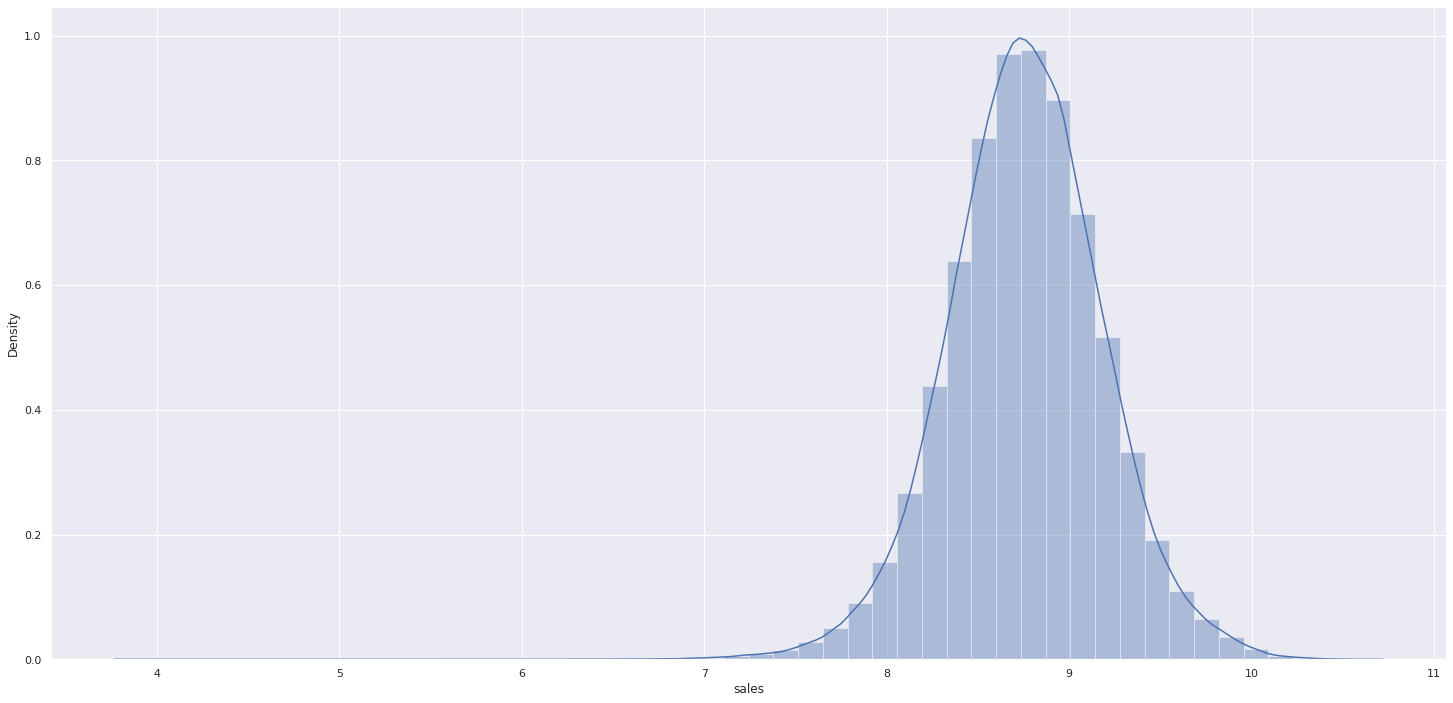

In [57]:
sns.distplot(df5['sales'])

#### 5.3.3 Nature Transformation

In [58]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2*np.pi)/12))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2*np.pi)/12))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2*np.pi)/30))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2*np.pi)/30))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi)/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi)/52))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2*np.pi)/7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2*np.pi)/7))


## 6.0  FEATURE SELECTION

In [59]:
df6 = df5.copy()

#### 6.1 Split dataframe into training and test datasets

In [60]:
cols_drop = ['week_of_year','day','month','day_of_week', 'promo_since', 'competition_since','week']
df6 = df6.drop(cols_drop, axis=1)

In [61]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [62]:
#training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales'] 

#test_dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales'] 

print('Training Dataset Min date: {}'.format(x_train['date'].min()))
print('Training Dataset Max date: {}'.format(x_train['date'].max()))

print('Test Dataset Min date: {}'.format(x_test['date'].min()))
print('Test Dataset Max date: {}'.format(x_test['date'].max()))

Training Dataset Min date: 2013-01-01 00:00:00
Training Dataset Max date: 2015-06-18 00:00:00
Test Dataset Min date: 2015-06-19 00:00:00
Test Dataset Max date: 2015-07-31 00:00:00


#### 6.2 Boruta as Feature Selector

***IMPORTANTE!!*** Os códigos dessa subseção foram comentados por que demandam o uso de recursos em quantidade indisponível.

In [63]:
#creating datasets for boruta
#x_train_n = x_train.drop(['date','sales'],axis=1).values
#y_train_n = y_train.values.ravel()

#defining RandomForestRegressor
#rf = RandomForestRegressor(n_jobs =-1)

#defining boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2, random_state=42).fit(x_train_n,y_train_n)

##### 6.2.1 Best Features from Boruta

In [64]:
#cols_selected = boruta.support_.tolist()

#x_train_fs = x_train.drop['date','sales']
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

#### 6.3 Manual Feature Selection

In [65]:
#Saving boruta output for don't use boruta again

cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# Columns to add
feat_to_add = ['date','sales']

# Final_feature - to cross validation
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 7.0  MACHINE LEARNING MODELLING

In [66]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

x_training = x_train[cols_selected_boruta_full]

***ATENÇÃO: com recursos mais limitados, se torna impossível realizar as predições usando Random Forest e XGBoost como estão aqui, por isso os snippets estão comentados. caso vc tenha mais que 8GB de RAM, deve funcionar. Os resultados que colarei abaixo foram obtidos por meio do uso do Google Collab.***

### 7.1 Average Model

In [67]:
#aux1 = x_test.copy()
#aux1['sales'] = y_test.copy()

#prediction
#aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'prediction'})
#aux1 = pd.merge(aux1,aux2,how='left',on='store')
#y_hat_baseline = aux1['prediction']

#performance
#baseline_result = ml_error('Average Model', np.expm1(y_test),np.expm1(y_hat_baseline))
#baseline_result


### 7.2 Linear Regression Model 

In [68]:
#model
#lr = LinearRegression().fit(X_train, y_train)

#prediction
#y_hat_lr = lr.predict(X_test)

#performance
#lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(y_hat_lr))
#lr_result

#### 7.2.1 - Cross Validation - Linear Regression

In [69]:
#Linear Regression cross Validation
#model_name = 'Linear Regression'
#k = 5
#lr_result_cv = cross_validation(x_training,k,model_name,lr)
#lr_result_cv 

### 7.3 Linear Regression Regularized Model - Lasso and Ridge

In [70]:
#model
#lrr = Lasso(alpha=0.01).fit(X_train, y_train)

#prediction
#y_hat_lrr = lrr.predict(X_test)

#performance
#lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(y_hat_lrr))
#lrr_result

In [71]:
#model
#lrr2 = Ridge(alpha=0.01).fit(X_train, y_train)

#prediction
#y_hat_lrr2 = lrr2.predict(X_test)

#performance
#lrr2_result = ml_error('Linear Regression - Ridge',np.expm1(y_test),np.expm1(y_hat_lrr2))
#lrr2_result

#### 7.3.1 - Cross Validation - Lasso and Ridge

In [72]:
#model_name = 'Lasso'
#k = 5
#lrr_result_cv = cross_validation(x_training,k,model_name,lrr)
#lrr_result_cv 

In [73]:
#model_name = 'Ridge'
#k = 5
#lrr2_result_cv = cross_validation(x_training,k,model_name,lrr2)
#lrr2_result_cv 

### 7.4 Random Forest Regression Model

In [74]:
#model
#rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(X_train, y_train)

#prediction
#y_hat_rf = rf.predict(X_test)

#performance
#rf_result = ml_error('Random Forest Regression',np.expm1(y_test),np.expm1(y_hat_rf))
#rf_result

#### 7.4.1 - Cross Validation - Random Forest

In [75]:
#Random Forest cross Validation
#model_name = 'Random Forest'
#k = 5
#rf_result_cv = cross_validation(x_training,k,model_name,rf)
#rf_result_cv 

### 7.5 XGBoost Regression Model

In [76]:
#model
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                      n_estimators=100,
#                      eta=0.01,
#                      max_depth=10,
#                      subsample=0.7,
#                      colsample_bytree=0.9).fit(X_train, y_train)

#prediction
#y_hat_xgb = model_xgb.predict(X_test)

#performance
#xgb_result = ml_error('XGBoost Regression',np.expm1(y_test),np.expm1(y_hat_xgb))
#xgb_result

#### 7.5.1 - Cross Validation - XGBoost

In [77]:
#XGBoost cross Validation

#model_name = 'XGBoost'
#k = 5
#xgb_result_cv = cross_validation(x_training,k,model_name,model_xgb,True)
#xgb_result_cv 

### 7.6 Compare Models Performance

#### 7.6.1 Single Performance

In [78]:
#modeling_result = pd.concat([baseline_result,lr_result,lrr_result,lrr2_result,xgb_result]).reset_index().drop(columns='index')
#modeling_result.sort_values('RMSE')

Resultado completo:

In [79]:
Image(results_img)

FileNotFoundError: No such file or directory: 'img/complete_result.png'

FileNotFoundError: No such file or directory: 'img/complete_result.png'

<IPython.core.display.Image object>

#### 7.6.2 Real Performance - Cross Validation

In [80]:
#modeling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,lrr2_result_cv,xgb_result_cv]).reset_index().drop(columns='index')
#modeling_result_cv

## 8.0  HYPERPARAMETER FINE TUNING

### 8.1 Random Search

In [81]:
hp = {'n_estimators':[1500,1700,2500,3000,3500],
        'eta': [0.01,0.03],
        'max_depth':[3,5,9],
        'subsample': [0.1,0.5,0.7],
        'colsample_bytree': [0.3,0.7,0.9],
        'min_child_weight':[3,8,15]}
MAX_EVAL = 5
kfold = 5

In [82]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
#    hp = {k : random.sample(v,1)[0] for k,v in param.items()}
#    print(hp)
    
    #model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                          n_estimators=hp['n_estimators'],
#                          eta=hp['eta'],
#                          max_depth=hp['max_depth'],
#                          subsample=hp['subsample'],
#                          colsample_bytree=hp['colsample_bytree'],
#                          min_child_weight=hp['min_child_weight'])
    
    #performance

#    result = cross_validation(x_training,kfold, "XGBoost Regressor", model_xgb, verbose = False)
#    final_result = pd.concat([final_result,result])

#final_result

### 8.2 Final Model

In [97]:
#param_tuned = {'n_estimators':3000,
#        'eta': 0.01,
#        'max_depth': 9,
#        'subsample':0.1,
#        'colsample_bytree':0.7,
#        'min_child_weight':8}

param_tuned = {'n_estimators':1000,
        'eta': 0.01,
        'max_depth': 9,
        'subsample':0.1,
        'colsample_bytree':0.7,
        'min_child_weight':8}

In [98]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                      n_estimators=param_tuned['n_estimators'],
                      eta=param_tuned['eta'],
                      max_depth=param_tuned['max_depth'],
                      subsample=param_tuned['subsample'],
                      colsample_bytree=param_tuned['colsample_bytree'],
                      min_child_weight=param_tuned['min_child_weight']).fit(X_train,y_train)


#predition
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)



#performance

xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,995.905117,0.146884,1453.13162


In [99]:
#Saving trained model - made in step 10

with open(pickle_model_paths+'rossman_low-memo.pkl','wb') as file:
    pickle.dump(model_xgb_tuned,file)



#Saving and loading main results to not to run the model again

#with open (pickle_parameter_paths+'yhat_xgb_tuned.pkl','wb') as f:
#    pickle.dump(yhat_xgb_tuned,f)

#with open (pickle_parameter_paths+'yhat_xgb_tuned.pkl','rb') as f:
#    yhat_xgb_tuned = pickle.load(f)

In [100]:
xgb_result_tuned['MPE'] = mean_percentage_error(np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,995.905117,0.146884,1453.13162,-0.016036


## 9.0  ERRORS TRANSLATION AND INTERPRETATION

In [101]:
df9 = x_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 9.1 Business Performance

In [102]:
#sum of predictions

df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge results

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how ='inner', on='store')
df92 = pd.merge(df91,df9_aux3, how='inner', on='store')


In [103]:
#possible scenarios estimated
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#reorder columns
df92 = df92 [['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [104]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
285,286,212688.546875,210627.964382,214749.129368,2060.582493,0.708517
291,292,115590.796875,112006.970215,119174.623535,3583.826660,0.688332
424,425,189500.546875,187542.694362,191458.399388,1957.852513,0.681853
472,473,192506.828125,190583.183937,194430.472313,1923.644188,0.629755
487,488,217905.546875,215753.153875,220057.939875,2152.393000,0.594102


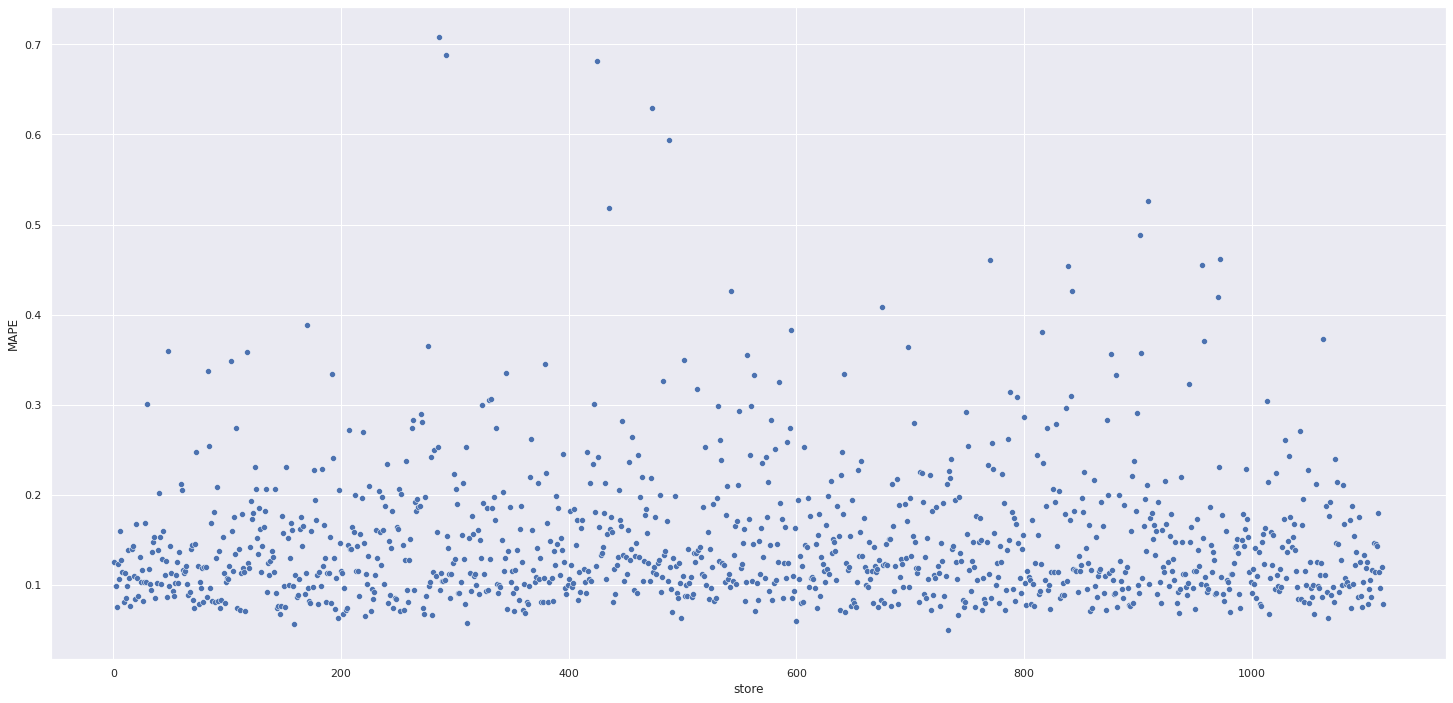

In [105]:
sns.scatterplot(x='store', y='MAPE', data=df92)

### 9.2 Total Performance

In [106]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenarios',0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)

df93

,Scenarios,Values
0,predictions,"R$ 278,788,160.00"
1,worst_scenario,"R$ 277,675,119.31"
2,best_scenario,"R$ 279,901,190.82"


### 9.3 Machine Learning Performance

In [107]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/dimitri/anaconda3/envs/DsEmProducao/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


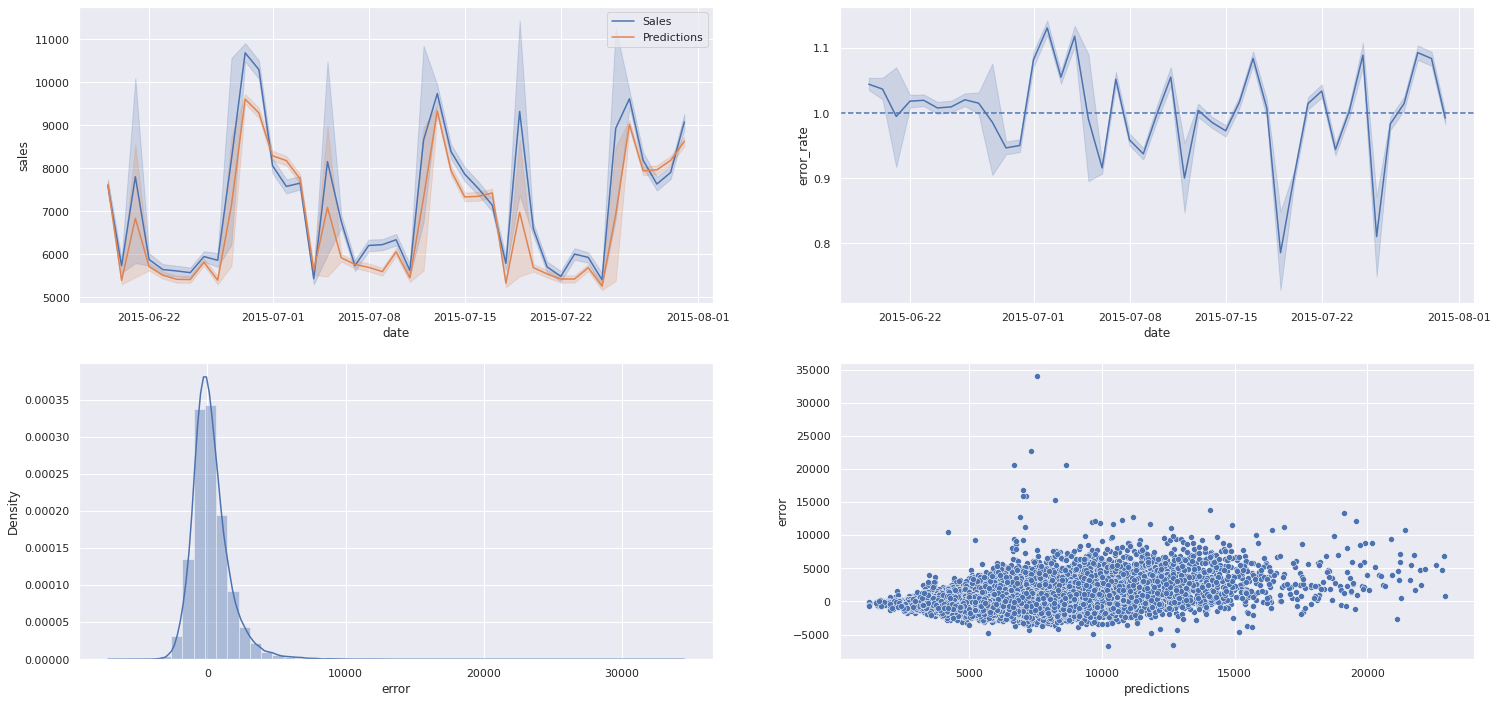

In [108]:
plt.subplot(2,2,1)

sns.lineplot(x='date',y='sales',data=df9,label='Sales')
sns.lineplot(x='date',y='predictions',data=df9,label='Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline(1.0, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x='predictions',y='error',data=df9)

## 10.0 DEPLOY MODEL TO PRODUCTION

### 10.1 Rossman Class

In [95]:
import pickle
import inflection
import math
import datetime

import pandas as pd
import numpy as np


class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/dimitri/github/DsEmProducao/'
        self.store_type_scaler             = pickle.load(open(self.home_path+'parameter/store_type_scaler.pkl','rb'))
        self.year_scaler                   = pickle.load(open(self.home_path+'parameter/year_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path+'parameter/promo_time_week_scaler.pkl','rb'))
        self.competition_distance_scaler   = pickle.load(open(self.home_path+'parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path+'parameter/competition_time_month_scaler.pkl','rb')) 
    
    
    def data_cleaning(self, df1):
        
        #Rename columns
        cols_old = df1.columns
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new

        #Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        #Fillout NA's
        #competition_
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        
        #promo2_
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        #promo_interval
        month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        #Change Types
        
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        return df1

    
    def feature_engineering (self,df2):
        
        #date
        df2['year'] = df2['date'].dt.year
        df2['month'] = df2['date'].dt.month
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #week
        df2['week'] = df2['date'].dt.strftime( '%Y-%W' )

        #competition
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] ,month= x['competition_open_since_month'], day= 1 ), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

        #promo
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days = 7) )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #state holiday and assortment
        df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        #rows Filtering
        df2 = df2[df2['open'] !=0]

        #columns Selection
        cols_drop = ['open','promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self,df5):
        
        #Rescaling
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'],columns=['state_holiday'])

        df5['store_type'] = self.store_type_scaler .fit_transform(df5[['store_type']]) 

        assortment_dict = {'basic':1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #Nature Transformation

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2*np.pi)/12))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2*np.pi)/12))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2*np.pi)/30))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2*np.pi)/30))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi)/52))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi)/52))

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2*np.pi)/7))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2*np.pi)/7))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                        'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        
        #prediction
        pred = model.predict( test_data)
        
        #join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso' )

### 10.2 API Handler

In [96]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
print('Loading predictor model...')
model = pickle.load(open('/home/dimitri/github/DsEmProducao/model/xgb_model.pkl','rb'))
print('Loaded!')


print("\n========= INITIALIZING SERVER ==========\n\n")

#initialize api
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json,dict): #unique example
            test_raw = pd.DataFrame(test_json,index=[0])
        else: #multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        #instantiate Rossman class
        pipeline = Rossmann()

        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    else:
    	return Response('{}',status=200, mimetype='application/json')



if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

### 10.3 API Tester

In [114]:
import requests

#loading test dataset
df_store_raw = pd.read_csv(data_path+'store.csv', low_memory=False)
df10 = pd.read_csv('/home/dimitri/github/DsEmProducao/data/test.csv')

#merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left',on='Store')
df_test = df_test[df_test['Store']==22] #choosing some stores to make predictions

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id',axis=1)


#convert df to json
data = json.dumps(df_test.to_dict(orient='records'))


In [115]:
#API CALL
url = 'https://rossmann-test.herokuapp.com/rossmann/predict'
#url ='http://0.0.0.0:5000/rossmann/predict'
header ={'Content-type':'application/json'}
data = data
r = requests.post(url, data, headers=header)

print('Status Code: {}'.format(r.status_code))

Status Code: 200


In [116]:
d1 = pd.DataFrame(r.json(), columns= r.json()[0].keys())
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format(d2.loc[i,'store'],d2.loc[i,'prediction']))

Store Number 22 will sell R$ 186,059.71 in the next 6 weeks.
